# Exercise 7 | Tube MPC

## Problem 1

Design a tube MPC controller for the following linear system:

$$x^+ = Ax + Bu + w,  A=\begin{bmatrix}1 & 1 \\ 0 & 1\end{bmatrix}, B=\begin{bmatrix}1 \\ 0.5\end{bmatrix} $$

with constraints and bounded disturbance

$$\mathcal{X} = \{x \mid \|x\|_{\infty} \leq 3 \}, \quad \mathcal{U} = \{u \mid ~\|u\|_{\infty} \leq 0.5 \} \quad \mathcal{W} = \{w \mid \|w\|_{\infty} \leq 0.1 \} $$

The matrix $K$ is the LQR gain with $Q=I$ and $R=10$.



In [355]:
import numpy as np
from mpt4py import Polyhedron
from control import dlqr

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

A = np.array([[1., 0.], [0.5, 1.]])
B = np.array([[0.00865235], [0.00021631]])

# A = np.array([[1., 1.], [0., 1.]])
# B = np.array([[1.], [0.5]])

xs = np.array([[0.0],[3.0]]) 
us = np.array([[56.66666667]])


Q = np.diag([10.0, 50.0])
R = 0.1 * np.eye(1)

K, Qf, _ = dlqr(A, B, Q, R)
K = -K

print(A)
print(B)
print(K)
A_cl = A + B @ K

print(K)

eigvals = np.linalg.eigvals(A_cl)
norm_eigen = np.max(np.abs(eigvals))
print(norm_eigen)


# x_max = 3.
# u_max = 0.5
# w_max = 0.1

# A_X = np.vstack((np.eye(2), -np.eye(2)))
# b_X = np.hstack(( x_max*np.ones(2),  x_max*np.ones(2)))
# X = Polyhedron.from_Hrep(A=A_X, b=b_X)
# U = Polyhedron.from_Hrep(A=np.vstack((np.eye(1), -np.eye(1))), b=u_max*np.ones(2))
# W = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=w_max*np.ones(4))

# A_W = np.vstack((np.eye(2), -np.eye(2)))
# b_W = np.hstack((w_max*np.ones(2), w_max*np.ones(2)))
# W = Polyhedron.from_Hrep(A=A_W, b=b_W)


v_min_phys, v_max_phys = -2.0, 2.0
z_min_phys, z_max_phys = 0.0, 12.0
lower_X = np.array([
    v_min_phys - xs[0, 0], z_min_phys - xs[1, 0]
])
upper_X = np.array([
    v_max_phys - xs[0, 0], z_max_phys - xs[1, 0]
])
A_X = np.vstack((np.eye(2), -np.eye(2)))
b_X = np.concatenate((upper_X, -lower_X))
X = Polyhedron.from_Hrep(A=A_X, b=b_X)


Pavg_min_phys, Pavg_max_phys = 40.0, 90.0
Pavg_min = Pavg_min_phys - us[0, 0]
Pavg_max = Pavg_max_phys - us[0, 0]
A_U = np.vstack((np.eye(1), -np.eye(1)))
b_U = np.array([Pavg_max, -Pavg_min])
U = Polyhedron.from_Hrep(A=A_U, b=b_U)


w_min_u, w_max_u = -15.0, 5.0
W_u = Polyhedron.from_Hrep(
    A=np.vstack((np.eye(1), -np.eye(1))),
    b=np.array([w_max_u, -w_min_u])
)
W = W_u.affine_map(B)



[[1.  0. ]
 [0.5 1. ]]
[[0.00865235]
 [0.00021631]]
[[-50.32374428 -17.8603615 ]]
[[-50.32374428 -17.8603615 ]]
0.7987396483133112


### Task 1
Implement a function to compute the minimum robust invariant set $\mathcal{E}$. 

Plot $\mathcal{X}$ and $\mathcal{E}$. How do you expect their Pontryagin difference $\mathcal{X}\ominus\mathcal{E}$ to look like?

**Hints:** 

- When computing your invariant sets, you will iterate through $\mathcal{F}_0, \mathcal{F}_1, \mathcal{F}_2, ...$ as we’ve seen in the lecture and the complexity of these sets will grow rapidly. Therefore, it’s a good idea to call `F.minHrep()` or `F.minVrep()` regularly to reduce the size of these sets. 

- Using the algorithm from the lectures leads to an infinite number of iterations and therefore you have to terminate it after a fixed number. Terminate when the size of the set you’re
adding is sufficiently small. A good termination condition will be $\|(A+BK)^i \|_2 < 10^{-2}$.

- The affine map of a polyhedron $P$ under a matrix $T$ is defined as $Q:=\{y \mid y=Tx, x\in P\}$. In *mpt4py*, this can be computed by `P.affine_map(T)` or `T @ P`.

Minimal robust invariant set computation converged after 26 iterations.
A U =
 [[ 1.]
 [-1.]]
b U =
 16.666666660000004
A =
 [[-1.]
 [ 1.]]
b =
 14.35847900943638


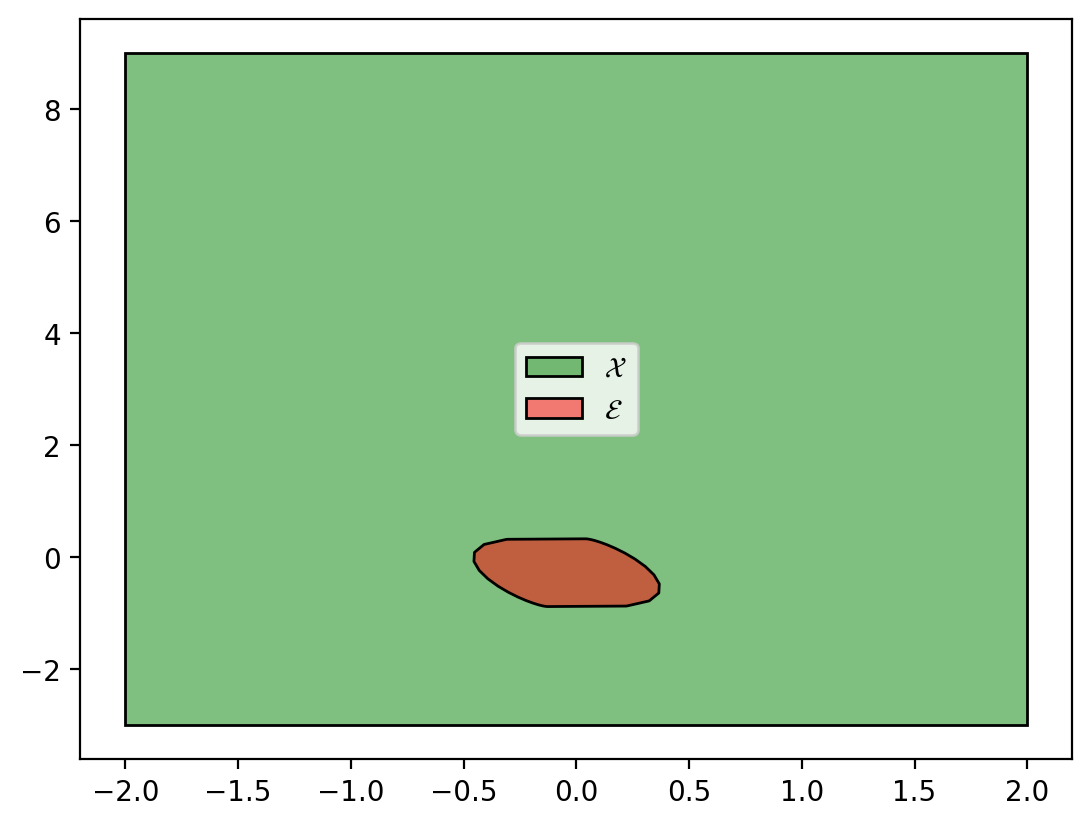

In [349]:
# ========= [SOLUTION] ============

def debug_poly(name, P: Polyhedron):
    print(f"\n--- {name} ---")
    print("A shape:", P.A.shape)
    print("b shape:", P.b.shape)
    print("A =\n", P.A)
    print("b =\n", P.b)
    print("is empty ?", P.is_empty)

# Compute minimal robust invariant set
def min_robust_invariant_set(A_cl: np.ndarray, W: Polyhedron, max_iter: int = 50) -> Polyhedron:
	nx = A_cl.shape[0]
	Omega = W
	itr = 0
	A_cl_ith_power = np.eye(nx)
	while itr <= max_iter:
		A_cl_ith_power = np.linalg.matrix_power(A_cl, itr)
		Omega_next = Omega + A_cl_ith_power @ W
		Omega_next.minHrep()  # optionally: Omega_next.minVrep()
		if np.linalg.matrix_norm(A_cl_ith_power, ord=2) < 1e-2:
			print('Minimal robust invariant set computation converged after {0} iterations.'.format(itr))
			break

		if itr == max_iter:
			print('Minimal robust invariant set computation did NOT converge after {0} iterations.'.format(itr))
		
		Omega = Omega_next
		itr += 1
	return Omega_next

E = min_robust_invariant_set(A_cl, W)

KE = E.affine_map(K)

print("A U =\n", U.A)
print("b U =\n", U.b[0]-U.b[1])

print("A =\n", KE.A)
print("b =\n", -KE.b[0]+ KE.b[1])

# Visualization
fig1, ax1 = plt.subplots(1, 1)
X.plot(ax1, color='g', opacity=0.5, label=r'$\mathcal{X}$')
E.plot(ax1, color='r', opacity=0.5, label=r'$\mathcal{E}$')
plt.legend()
plt.show()

### Task 2

Compute the tightened state constraints $\tilde{\mathcal{X}} \coloneqq \mathcal{X}\ominus \mathcal{E}$, tightened input constraints $\tilde{\mathcal{U}} \coloneqq \mathcal{U}\ominus K\mathcal{E}$. Plot $\mathcal{\tilde{X}}$ together with $\mathcal{X}$ and $\mathcal{E}$. Does $\mathcal{\tilde{X}}$ match the intuition you developed in Task 1?

Compute the terminal set $\mathcal{X}_f$ for nominal MPC and $\tilde{\mathcal{X}}_f$ for tube MPC. Plot them on a new figure.

**Hints**: 

- You can reuse your code from exercise 3 to compute the terminal set for nominal MPC $\mathcal{X}_f$.

- In mpt4py, the Pontryagin difference of two polyhedra $A\ominus B$ can be easily computed from `A - B` or `A.pontryagin_difference(B)`, where `A` and `B` are two objects of `Polyhedron` class.

- You can compute $K\mathcal{E} := \{ Ke \mid e \in \mathcal{E} \}$ with `E.affine_map(K)` or `K @ E`.

Are the two tightened sets equal? True


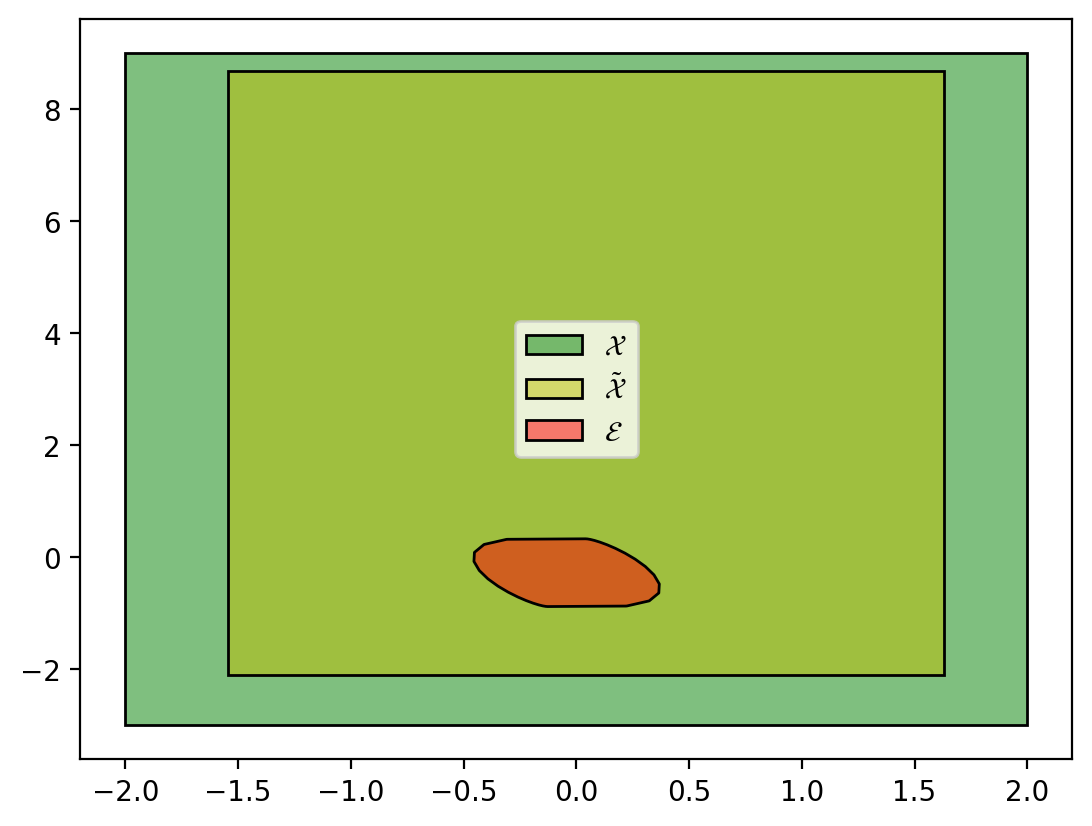

In [350]:
# ========= [SOLUTION] ============

# tightened state constraints
X_tilde = X - E 

# tightened input constraints
# we provide two equivalent methods to compute the tightened input constraints. You can verify that they yield the same result.

KE = E.affine_map(K)  # optionally: K @ E

# option 1: direct Pontryagin difference
U_tilde_1 = U - KE 

# option 2: manual tightening the right-hand side via support function
# tilde_U = { u | A u <= b - max_{e in E} A K e }
U_tilde_b = U.b.copy()
for i in range(U_tilde_b.shape[0]):
	U_tilde_b[i] -= KE.support(U.A[i,:])
U_tilde_2 = Polyhedron.from_Hrep(A=U.A, b=U_tilde_b)


print("Are the two tightened sets equal?", U_tilde_1 == U_tilde_2)
U_tilde = U_tilde_1  # or U_tilde_2

# visualization
fig2, ax2 = plt.subplots(1, 1)
X.plot(ax2, color='g', opacity=0.5, label=r'$\mathcal{X}$')
X_tilde.plot(ax2, color='y', opacity=0.5, label=r'$\mathcal{\tilde{X}}$')
E.plot(ax2, color='r', opacity=0.5, label=r'$\mathcal{E}$')
plt.legend()
plt.show()


Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Maximum invariant set successfully computed after 5 iterations.

Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Iteration 5... not yet converged
Maximum invariant set successfully computed after 6 iterations.



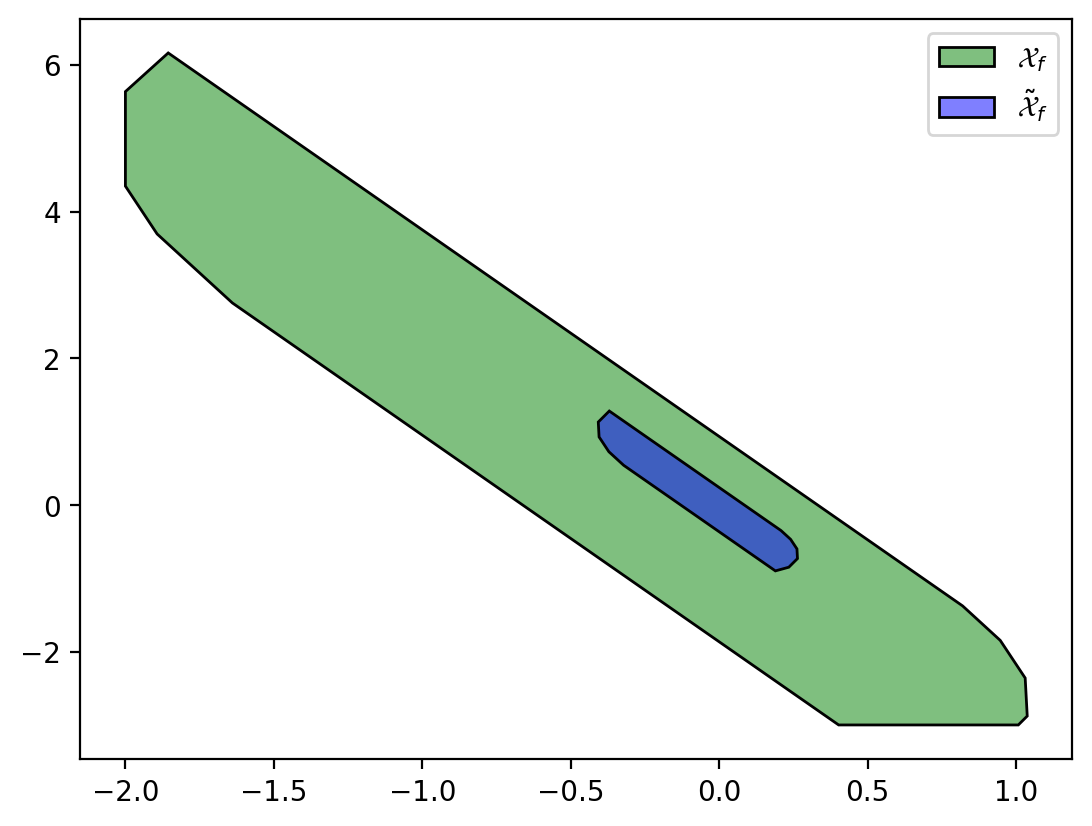

In [351]:
# ========= [SOLUTION] ============
def max_invariant_set(A_cl, X: Polyhedron, max_iter = 50) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	O = X
	itr = 1
	converged = False
	while itr < max_iter:
		Oprev = O
		F, f = O.A, O.b
		# Compute the pre-set
		O = Polyhedron.from_Hrep(np.vstack((F, F @ A_cl)), np.vstack((f, f)).reshape((-1,)))
		O.minHrep()
		if O == Oprev:
			converged = True
			break
		print('Iteration {0}... not yet converged'.format(itr))
		itr += 1
	
	if converged:
		print('Maximum invariant set successfully computed after {0} iterations.\n'.format(itr))
	return O


# Compute the terminal set for nominal mpc
X_and_KU = X.intersect(Polyhedron.from_Hrep(U.A@K, U.b))
Xf = max_invariant_set(A_cl, X_and_KU)

# Compute the terminal set for tube mpc
X_tilde_and_KU_tilde = X_tilde.intersect(Polyhedron.from_Hrep(U_tilde.A@K, U_tilde.b))
Xf_tilde = max_invariant_set(A_cl, X_tilde_and_KU_tilde)

# visualization
fig3, ax3 = plt.subplots(1, 1)
Xf.plot(ax3, color='g', opacity=0.5, label=r'$\mathcal{X}_f$')
Xf_tilde.plot(ax3, color='b', opacity=0.5, label=r'$\tilde{\mathcal{X}}_f$')
plt.legend()
plt.show()


### Task 3

Formulate the Tube MPC problem using CVXPY.

Use $N=10$ as the prediction horizon.


In [352]:
import cvxpy as cp

N = 20
# Define variables
nx, nu = B.shape
z_var = cp.Variable((N+1, nx), name='z')
v_var = cp.Variable((N, nu), name='v')
x0_var = cp.Parameter((nx,), name='x0')

## Costs
cost = 0
for i in range(N):
	cost += cp.quad_form(z_var[i], Q)
	cost += cp.quad_form(v_var[i], R)
cost += cp.quad_form(z_var[-1], Qf)


## Constraints
constraints = []

# initial condition: x0 in z0 + E
constraints.append(E.A @ (x0_var - z_var[0]) <= E.b)

# dynamics
constraints.append(z_var[1:].T == A @ z_var[:-1].T + B @ v_var.T)

# state constraints
constraints.append(X_tilde.A @ z_var[:-1].T <= X_tilde.b.reshape(-1, 1))

# input constraints
constraints.append(U_tilde.A @ v_var[:-1].T <= U_tilde.b.reshape(-1, 1))

# terminal set
constraints.append(Xf_tilde.A @ z_var[-1].T <= Xf_tilde.b.reshape(-1, 1))


tube_mpc = cp.Problem(cp.Minimize(cost), constraints)

### Task 4

Run closed-loop simulation with the tube MPC controller you designed, and generate several state–input trajectories starting from the same initial condition $x_0$. 

Plot the trajectories and verify that both the state and input constraints are robustly satisfied under the presence of disturbances $w\in\mathcal{W}$.

**Hints:** 

- If $x_0$ is randomly sampled from $\mathcal{\tilde{X}}$, the underlying optimization problem might be infeasible due to the relatively short horizon. To ensure feasibility, an option is to sample initial condition $x_0$ from the terminal set $\mathcal{\tilde{X}}_f$. 

- In *mpt4py*, you can uniformly sample $m$ points from a polyhedron $P\subset \mathbb{R}^n$ with `x_sampled = P.sample(m)`, where `x_sample` is a NumPy array with shape `(m, n)`.


========== DEBUG : INCLUSIONS ==========
E ⊂ X ? True
KE ⊂ U ? True
Xf_tilde ⊂ X_tilde ? True

========== DEBUG : FEASIBILITY ==========
X_tilde empty ? False
U_tilde empty ? False
Xf_tilde empty ? False


c:\Users\sebas\miniconda3\envs\mpc2025\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


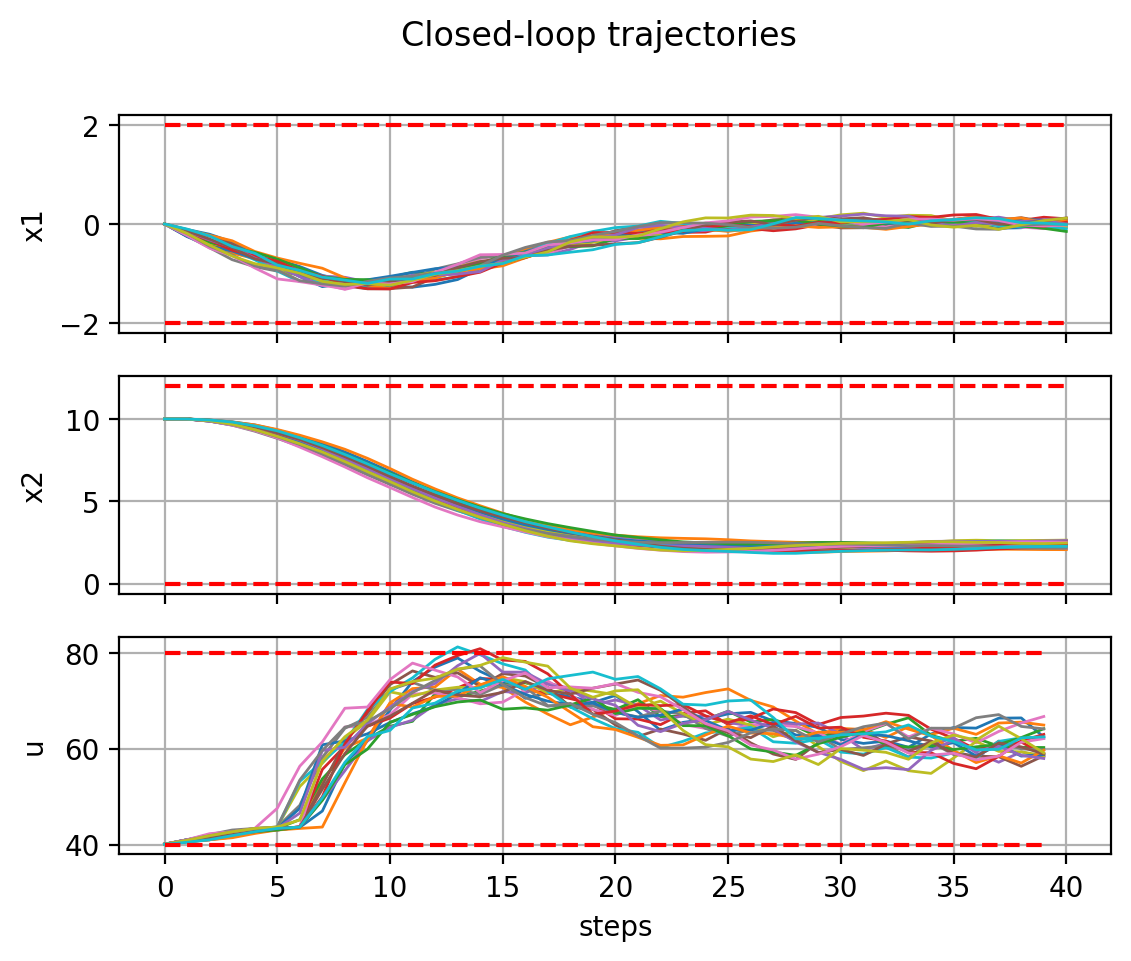

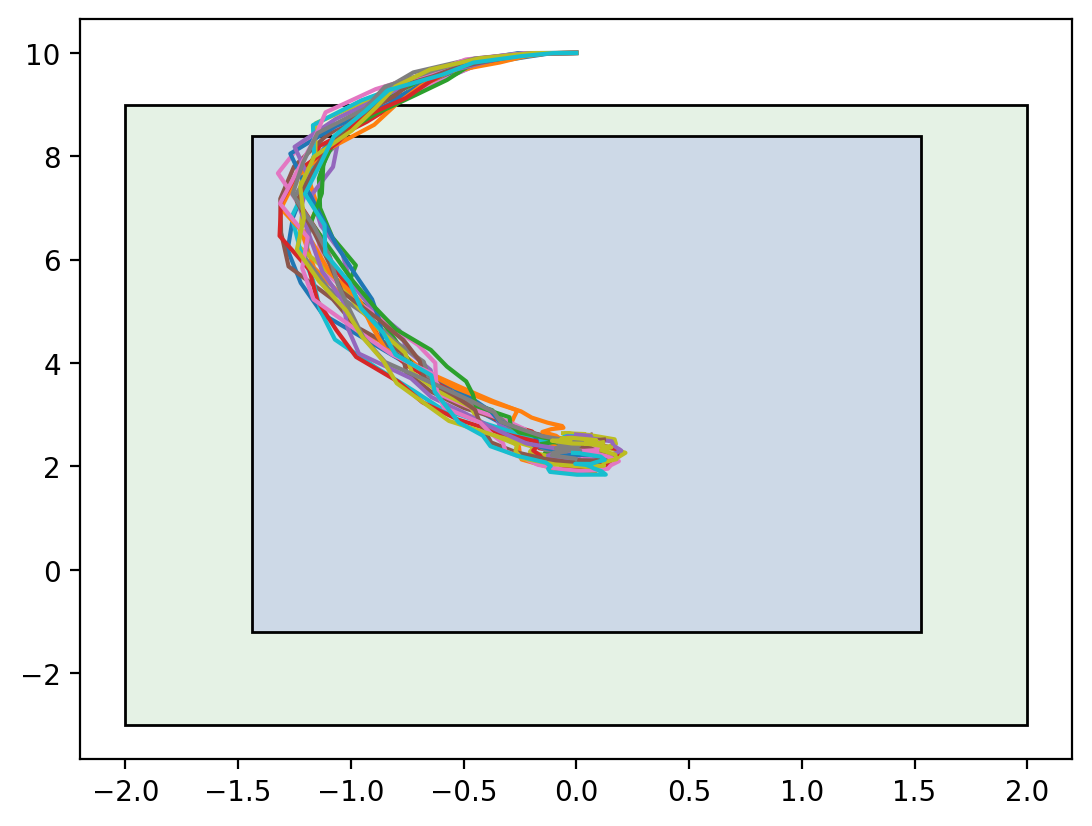

In [332]:
# ========= [SOLUTION] ============
print("\n========== DEBUG : INCLUSIONS ==========")
print("E ⊂ X ?", X.contains(E))
print("KE ⊂ U ?", U.contains(KE))
print("Xf_tilde ⊂ X_tilde ?", X_tilde.contains(Xf_tilde))

print("\n========== DEBUG : FEASIBILITY ==========")
print("X_tilde empty ?", X_tilde.is_empty)
print("U_tilde empty ?", U_tilde.is_empty)
print("Xf_tilde empty ?", Xf_tilde.is_empty)

# Closed-loop simulation of the state and input trajectories
num_samples = 20
N_closed_loop = 40
t_traj_closed_loop = np.arange(0, N_closed_loop+1)
x_trajs_closed_loop = np.zeros((num_samples, N_closed_loop+1, nx))
u_trajs_closed_loop = np.zeros((num_samples, N_closed_loop, nu))

x0 = np.array([[0.0],[10.0]]).flatten()

# for each sample trajectory
x0 = np.array([0.0, 10.0]) 

# for each sample trajectory
for i in range(num_samples):
    dxk = x0 - xs.flatten()
    x_trajs_closed_loop[i, 0] = x0

    for k in range(N_closed_loop):
        
        x0_var.value = dxk
        tube_mpc.solve(cp.PIQP)
        assert tube_mpc.status == cp.OPTIMAL, f"The tube mpc solver returned status: {tube_mpc.status}"

        dz = z_var[0].value
        dv = v_var[0].value

        du = dv + K @ (dxk - dz)
        uz = du + us

        w = W.sample(1).flatten()

        dxk = A @ dxk + (B @ du).flatten() + w 
        xk = dxk + xs.flatten()

        x_trajs_closed_loop[i, k+1] = xk
        u_trajs_closed_loop[i, k] = uz




def plot_trajs(t_traj_closed_loop: np.ndarray, 
               x_trajs_closed_loop: np.ndarray,
               u_trajs_closed_loop: np.ndarray):
	# Visualization of the trajectories
	fig, ax = plt.subplots(3, 1, sharex=True)
	t_traj = t_traj_closed_loop
	linewidth=1.

	for x_traj, u_traj in zip(x_trajs_closed_loop, u_trajs_closed_loop):
		ax[0].plot(t_traj, x_traj[:, 0], label=r'$p$', linewidth=linewidth)
		ax[1].plot(t_traj, x_traj[:, 1], label=r'$v$', linewidth=linewidth)
		ax[2].plot(t_traj[:-1], u_traj[:, 0], label=r'$a$', linewidth=linewidth)
		
	ax[0].plot(t_traj, -2 * np.ones_like(t_traj), color='red', linestyle='--')
	ax[0].plot(t_traj, 2 * np.ones_like(t_traj), color='red', linestyle='--')
	ax[0].grid()
	ax[0].set_ylabel('x1')

	ax[1].plot(t_traj, 0 * np.ones_like(t_traj), color='red', linestyle='--')
	ax[1].plot(t_traj, 12 * np.ones_like(t_traj), color='red', linestyle='--')
	ax[1].grid()
	ax[1].set_ylabel('x2')

	ax[2].plot(t_traj[:-1], 40 * np.ones_like(t_traj[:-1]), color='red', linestyle='--')
	ax[2].plot(t_traj[:-1], 80 * np.ones_like(t_traj[:-1]), color='red', linestyle='--')
	ax[2].grid()
	ax[2].set_ylabel('u')
	ax[2].set_xlabel('steps')

	fig.suptitle('Closed-loop trajectories')
	fig.align_ylabels()
	plt.show()
      
plot_trajs(t_traj_closed_loop, x_trajs_closed_loop, u_trajs_closed_loop)    

fig4, ax4 = plt.subplots(1, 1)
X.plot(ax4, opacity=0.1, color='g', label=r'$\mathcal{X}$')
X_tilde.plot(ax4, opacity=0.1, color='b', label=r'\tilde{\mathcal{X_tild}}')

for x_traj in x_trajs_closed_loop:
	ax4.plot(x_traj[:,0], x_traj[:,1])

plt.show()